In [77]:
#Importing libraries
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from matplotlib.dates import DateFormatter, DayLocator
from pylab import rcParams
import pickle
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
import warnings
# from fbprophet import Prophet
import torch
from torch import optim
from torch.nn import functional as F
from tqdm import tqdm
from nbeats_pytorch.model import NBeatsNet
from trainer_pytorch import save
from datetime import datetime
import calendar


warnings.filterwarnings(action='ignore', message='Setting attributes')

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# Data Preprocessing

In [78]:
df=pd.read_csv("Data/Dataset.csv")  #Reading the dataset

df=df.drop(['VORJAHRESWERT','VERAEND_VORMONAT_PROZENT','VERAEND_VORJAHRESMONAT_PROZENT','ZWOELF_MONATE_MITTELWERT'],axis=1) #Removing unwanted columns

df.columns = ['Category','Accident_Type','Year','Month','Value'] #Renaming for ease

categories=list(set(list(df['Category']))) #Listing all categories

accidents=list(set(list(df['Accident_Type']))) #Listing all Accidents

In [3]:
categories

['Alkoholunfälle', 'Fluchtunfälle', 'Verkehrsunfälle']

# Removing unwanted rows

In [4]:
cond = df.Month == 'Summe' #Removing rows with sum of all values for each category

rows = df.loc[cond, :]

df.drop(rows.index, inplace=True)

# Changing date format

In [5]:
df['Month'] = pd.to_datetime(df['Month'],format='%Y%m')

In [6]:
final=[]

# Removing other accidents types apart from "insgesamt"

In [7]:
for i in categories:
    
    df_tmp = pd.DataFrame(columns=df.columns)

    cond = df.Category == i #Condition to select category

    rows = df.loc[cond, :]

    df_tmp = df_tmp.append(rows, ignore_index=True)

    df.drop(rows.index, inplace=True)

    cond = df_tmp.Accident_Type != 'insgesamt' #Condition to select other accidents types for removal

    rows = df_tmp.loc[cond, :]

    df_tmp.drop(rows.index, inplace=True)
    
    final.append(df_tmp)

# Converting each dataframe to time indexed series

In [8]:
uni=[]

In [9]:
for i in final:
    
    data=i
    
    data = data.set_index('Month')

    data.index

    y=data['Value']

    y=y[:'2020']
       
    uni.append(y)

# Individual Plots for the entire time period from 2000-2020

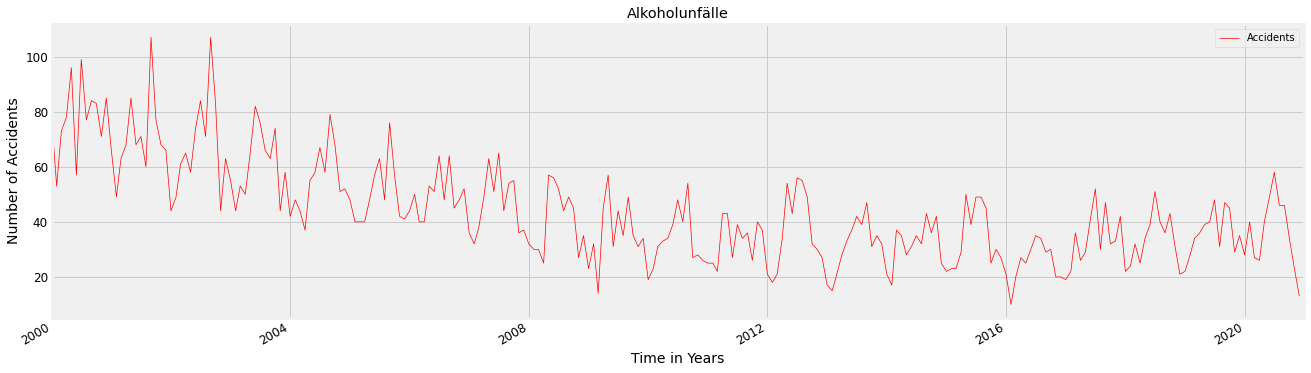

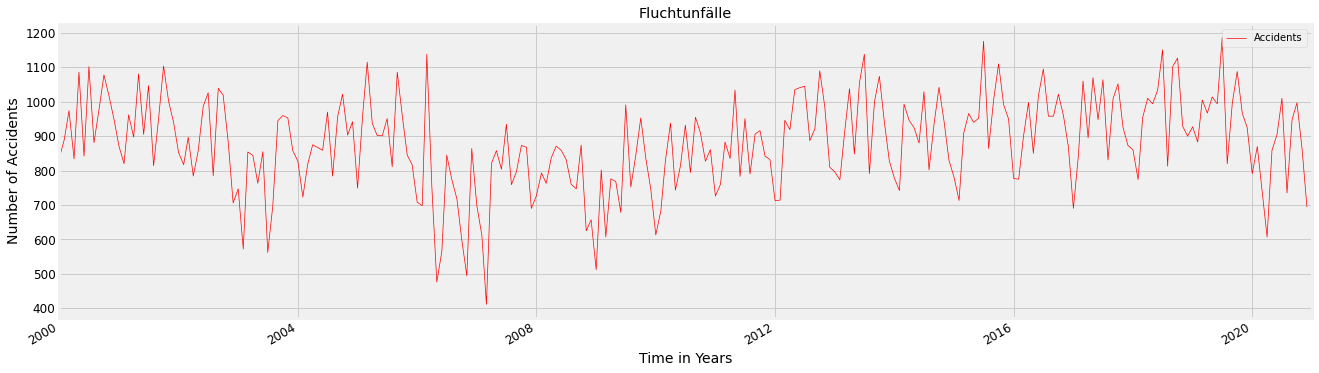

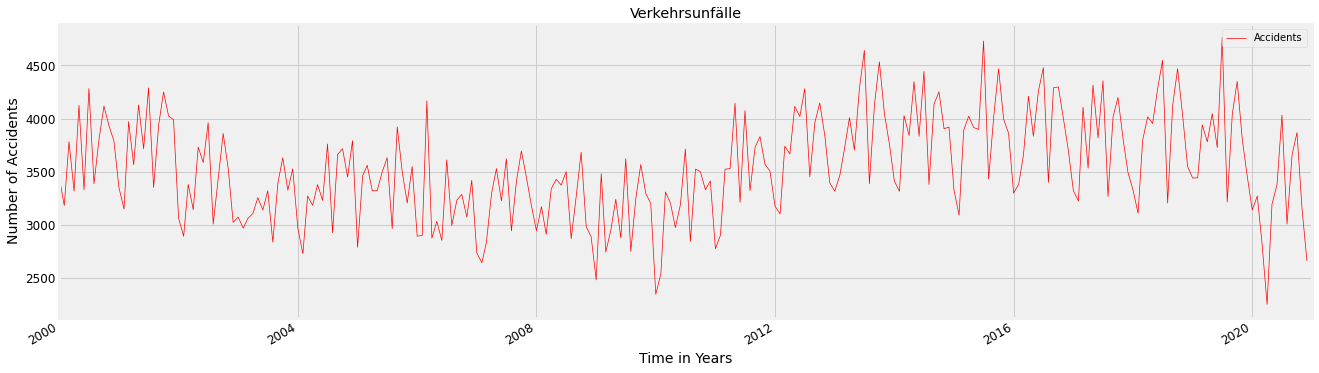

In [10]:
for i in range(len(categories)):
    
    ax=uni[i].plot(figsize=(20, 6),color='red',linewidth=0.7)

    ax.set_xlabel('Time in Years')

    ax.set_ylabel('Number of Accidents')

    ax.set_title(categories[i])

    ax.grid(True)

    ax.set_xlim(pd.Timestamp('2000'), pd.Timestamp('2021'))

    ax.legend(labels=['Accidents'],loc='upper right');

    plt.show()
    
    print('\n\n')

# Initial observations

* The time series for all three categories does not exhibit any clear trend. Furthermore, a slight decrease in alcohol accidents can be seen from 2008 onwards which might suggest better law enforcement and rules during this period.

* An unexpected drop in Traffic accidents (Verkehrdunfalle) can be seen around Mar'20 - Arp'20 perhaps due to Covid restrictions in Munich.

# Individual Plots for last 5 years (for better analysis)

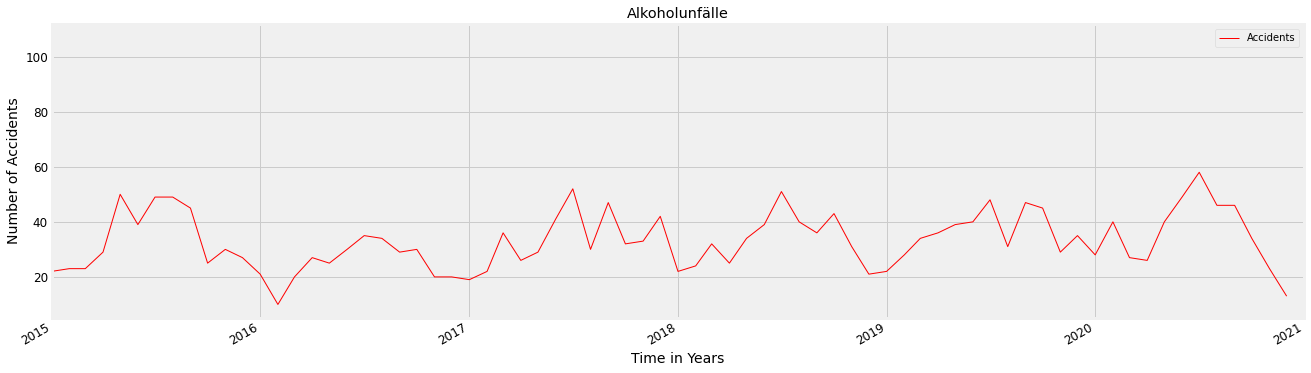

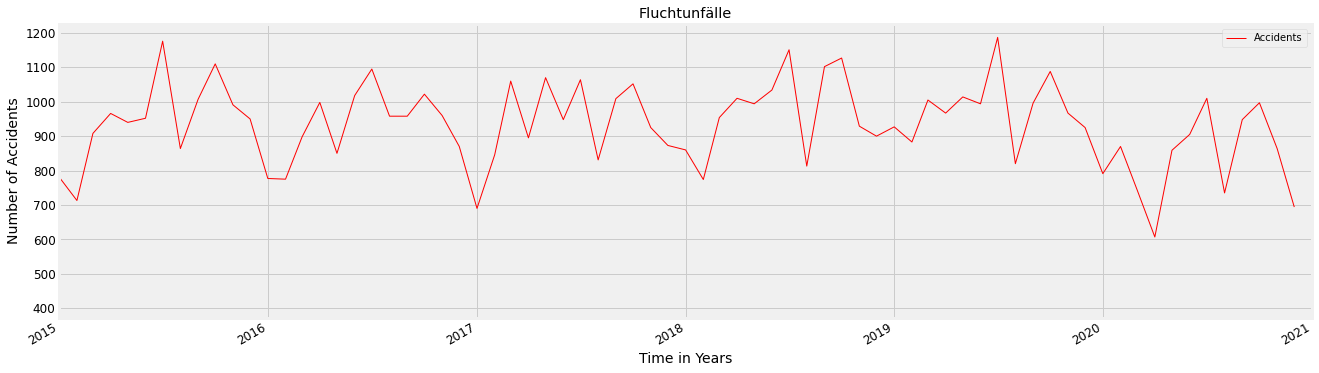

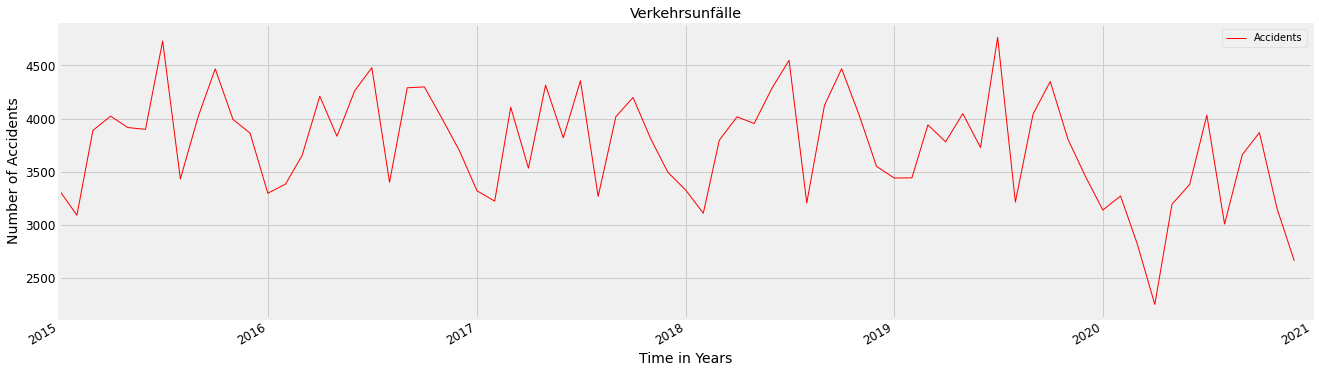

In [11]:
for i in range(len(categories)):
    
    ax=uni[i].plot(figsize=(20, 6),color='red',linewidth=1)

    ax.set_xlabel('Time in Years')

    ax.set_ylabel('Number of Accidents')

    ax.set_title(categories[i])

    ax.grid(True)

    ax.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2021-01-01'))

    ax.legend(labels=['Accidents'],loc='upper right');

    plt.show()
    
    print('\n\n')

# Initial observations

* Clear seasonality can be seen in all three categories wherein the accidents increase particularly in summers i.e. May-July and are often followed by a sudden decrease in accidents in Aug-Sept.

* As mentioned earlier, a clear decrease in accidents can be seen around Mar'20 - Apr'20 probably due to Covid restrictions and lack of Traffic and other public accidents.

* An increase in alcohol accidents can be seen just after the Covid restrictions period. An hypothesis stating the increase of alcohol consumption after ease in restrictions can be seen thus hinting at behavioural discomfort during restrictions amongst people.

# Overlapping graphs (Not Normalized)

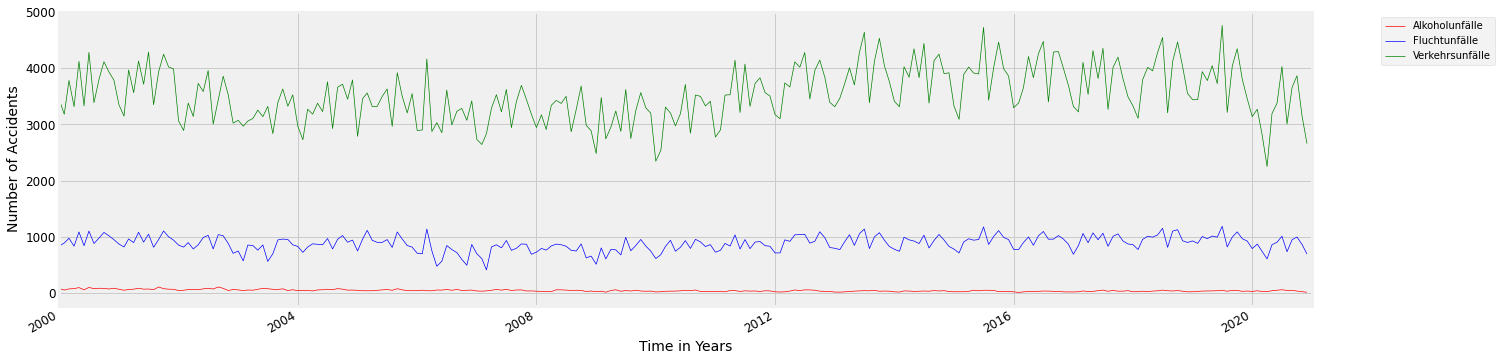

In [12]:
colours=['red','blue','green']

for i in range(len(categories)):
    
    ax=uni[i].plot(figsize=(20, 6),color=colours[i],linewidth=0.7)

    ax.set_xlabel('Time in Years')

    ax.set_ylabel('Number of Accidents')

    ax.grid(True)

    ax.set_xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2021-01-01'))

    ax.legend(labels=[categories[0],categories[1],categories[2]],loc='upper right',bbox_to_anchor=(1.15, 1));

plt.show()

# Normalization

In [13]:
nmz=[]
for i in uni:
    values = np.array(i)
    values = values.reshape((len(values), 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(values)
    normalized = scaler.transform(values)
    nmz.append(normalized)

In [14]:
normalize_plot=[]
for i in nmz:
    tmp=pd.DataFrame()
    cur=[]
    for j in i:
        cur.append(j.tolist()[0])
    tmp['value']=cur
    tmp = tmp.set_index(uni[0].index)
    normalize_plot.append(tmp['value'])   

# Normalized graphs

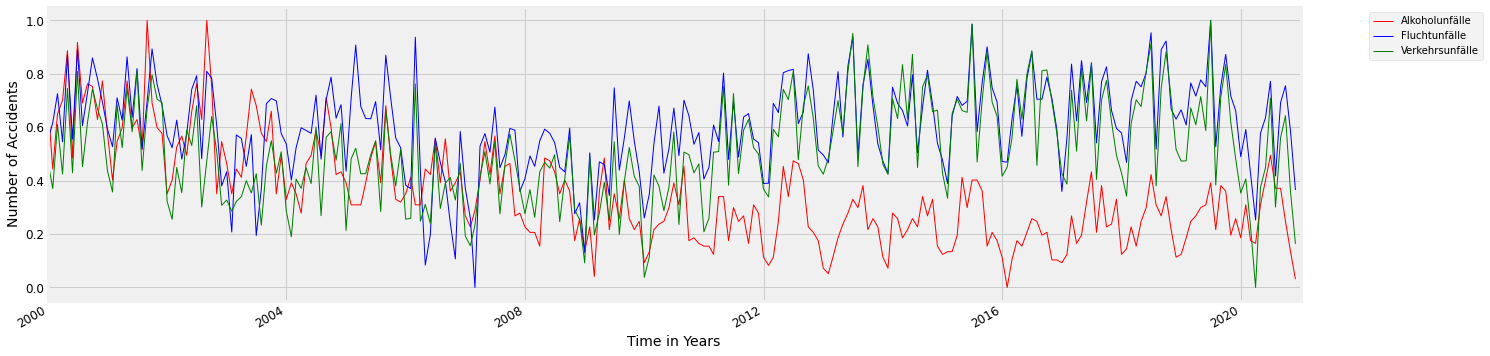

In [15]:
colours=['red','blue','green']

for i in range(len(categories)):
    
    ax=normalize_plot[i].plot(figsize=(20, 6),color=colours[i],linewidth=1)

    ax.set_xlabel('Time in Years')

    ax.set_ylabel('Number of Accidents')

    ax.grid(True)

    ax.set_xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2021-01-01'))

    ax.legend(labels=[categories[0],categories[1],categories[2]],loc='upper right',bbox_to_anchor=(1.15, 1));

plt.show()

# Selected category for prediction : Alkoholunfälle

In [16]:
for i in uni:
    i.sort_index(inplace= True)
data=uni[0]

In [17]:
data

Month
2000-01-01    78.0
2000-02-01    53.0
2000-03-01    73.0
2000-04-01    78.0
2000-05-01    96.0
              ... 
2020-08-01    46.0
2020-09-01    46.0
2020-10-01    34.0
2020-11-01    23.0
2020-12-01    13.0
Name: Value, Length: 252, dtype: float64

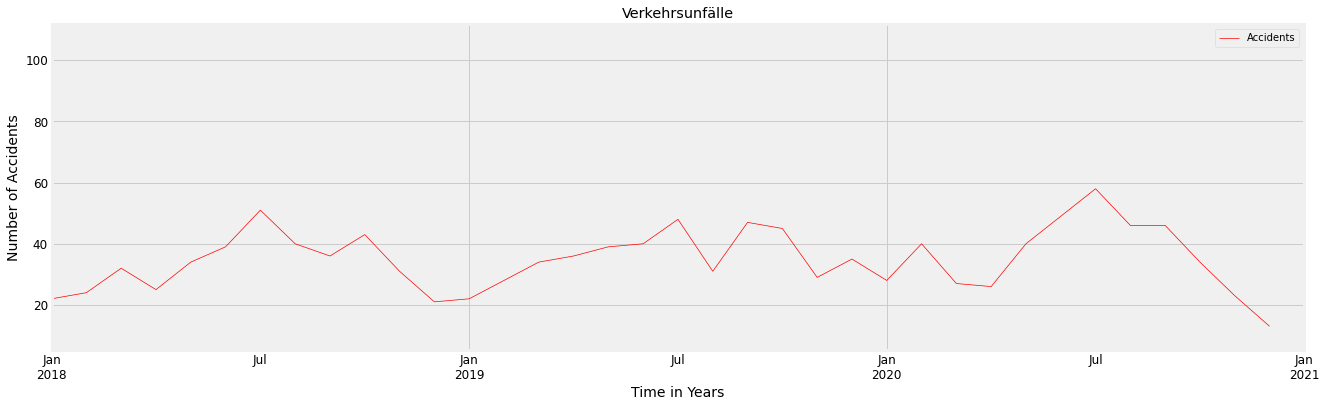

In [18]:
ax=data.plot(figsize=(20, 6),color='red',linewidth=0.7)

ax.set_xlabel('Time in Years')

ax.set_ylabel('Number of Accidents')

ax.set_title(categories[2])

ax.grid(True)

ax.set_xlim(pd.Timestamp('2018'), pd.Timestamp('2021'))

ax.legend(labels=['Accidents'],loc='upper right');

plt.show()

# Decomposing the time series for better trends and seasonality analysis

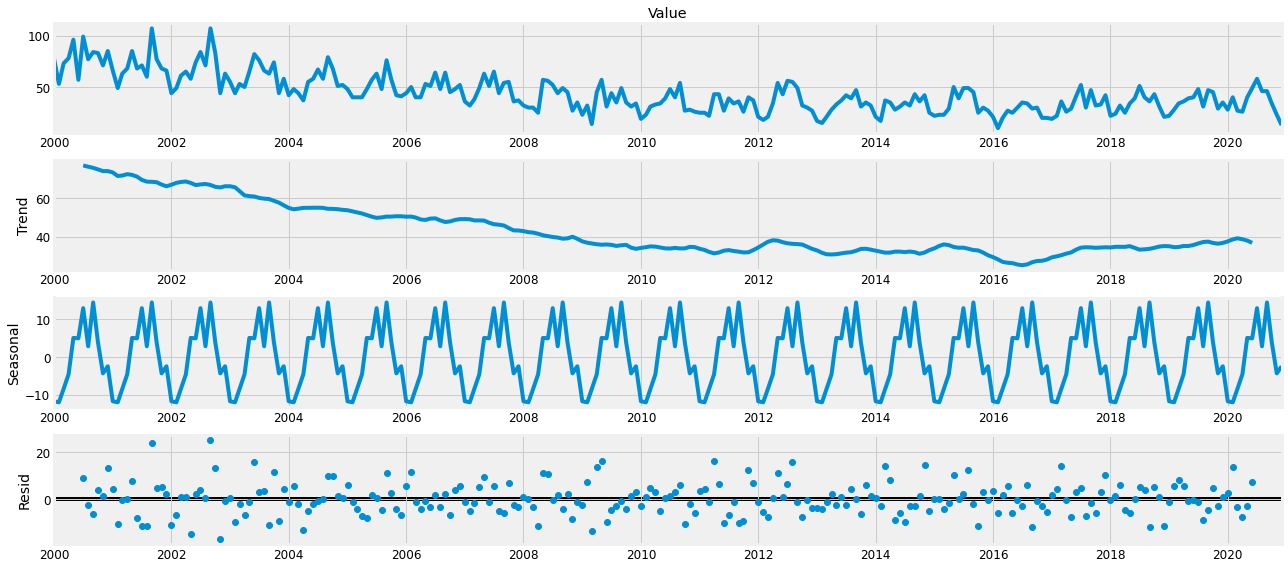

In [19]:
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(data, model='additive')

fig = decomposition.plot()

plt.show()

# Observations

* A clear seasonality can be observed throughout the time series as explained previously. There is a spike in accidents in May - Jul followed by a sharp decrease in Aug - Sept.
* Overall the number of alcoohol accidents have decreased over time but have been stable for quite a long period.

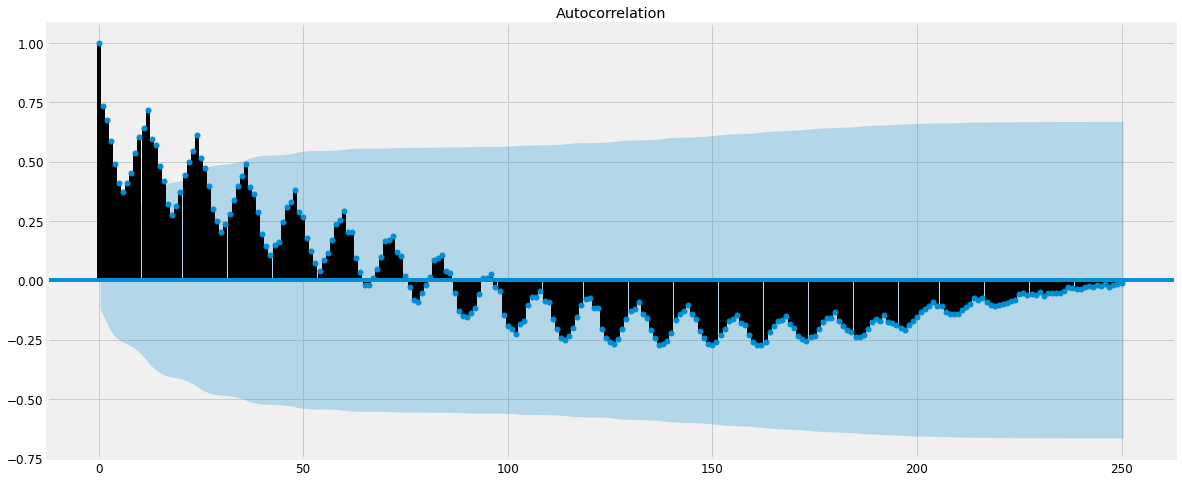

In [20]:
acf=plot_acf(data,lags=250)

# Observation

* A diminishing correlation can be observed for the time series over 250 lags thus suggesting that an autoregressive model can be indeed used for prediction of such data.
* Correlation is particularly high for lags 1 and 2 thus suggesting that AR(1) or AR(2) can be helpful in prediction.

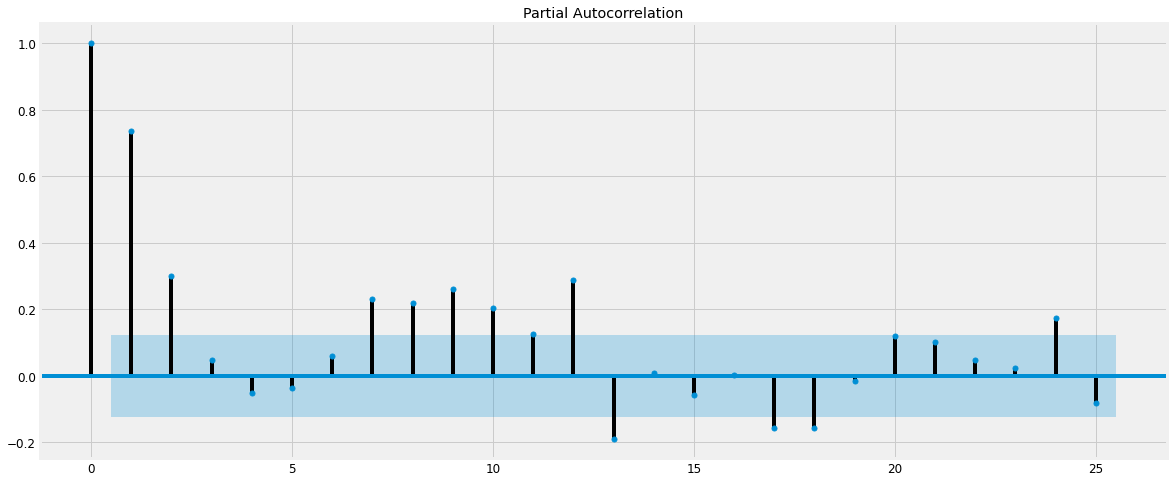

In [21]:
acf=plot_pacf(data)

In [22]:
data

Month
2000-01-01    78.0
2000-02-01    53.0
2000-03-01    73.0
2000-04-01    78.0
2000-05-01    96.0
              ... 
2020-08-01    46.0
2020-09-01    46.0
2020-10-01    34.0
2020-11-01    23.0
2020-12-01    13.0
Name: Value, Length: 252, dtype: float64

In [23]:
data.index = pd.DatetimeIndex(data.index.values,freq=data.index.inferred_freq)

# Dickey Fuller Test to check for stationarity

In [24]:
def test_stationarity(timeseries,maxlag):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag=maxlag,
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (round(dfoutput,3))
test_stationarity(data,maxlag=4)

Results of Dickey-Fuller Test:
Test Statistic                  -4.025
p-value                          0.001
#Lags Used                       1.000
Number of Observations Used    250.000
Critical Value (1%)             -3.457
Critical Value (5%)             -2.873
Critical Value (10%)            -2.573
dtype: float64


* Since the p value is less than 0.05 for first 4 lags, it suggests that the series is stationary and the SARIMAX parmeter d can thus be set to 1

# SARIMAX Parameter Calculation via Grid Search

In [26]:
def sarimax(ts,all_param):
    results = []
    cons=[]
    best=float('inf')
    for param in all_param:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,order=param[0],seasonal_order=param[1],enforce_stationarity=False,enforce_invertibility=False)
            res = mod.fit()
            results.append((res,res.aic,param))
            print('Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], round(res.aic,2)))
            if res.aic<best: # checking for best combination of parameters
                best=res.aic
                cons=[param]
        except Exception as e:
            print(e)
            continue
            
    return results,cons,best

# setting parameter range
p,d,q = range(0,3),[1],range(0,3)
P,D,Q,s = range(0,3),[1],range(0,3),[12]

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq,seasonal_pdq))
all_res,cons,best = sarimax(data,all_param)

Tried out SARIMAX(0, 1, 0)x(0, 1, 0, 12) - AIC:1906.9
Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 12) - AIC:1703.18
Tried out SARIMAX(0, 1, 0)x(0, 1, 2, 12) - AIC:1595.47
Tried out SARIMAX(0, 1, 0)x(1, 1, 0, 12) - AIC:1748.58
Tried out SARIMAX(0, 1, 0)x(1, 1, 1, 12) - AIC:1698.68
Tried out SARIMAX(0, 1, 0)x(1, 1, 2, 12) - AIC:1596.52
Tried out SARIMAX(0, 1, 0)x(2, 1, 0, 12) - AIC:1609.53
Tried out SARIMAX(0, 1, 0)x(2, 1, 1, 12) - AIC:1596.86
Tried out SARIMAX(0, 1, 0)x(2, 1, 2, 12) - AIC:1583.84
Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 12) - AIC:1795.23
Tried out SARIMAX(0, 1, 1)x(0, 1, 1, 12) - AIC:1598.87
Tried out SARIMAX(0, 1, 1)x(0, 1, 2, 12) - AIC:1501.61
Tried out SARIMAX(0, 1, 1)x(1, 1, 0, 12) - AIC:1650.85
Tried out SARIMAX(0, 1, 1)x(1, 1, 1, 12) - AIC:1596.58
Tried out SARIMAX(0, 1, 1)x(1, 1, 2, 12) - AIC:1502.01
Tried out SARIMAX(0, 1, 1)x(2, 1, 0, 12) - AIC:1519.28
Tried out SARIMAX(0, 1, 1)x(2, 1, 1, 12) - AIC:1513.81
Tried out SARIMAX(0, 1, 1)x(2, 1, 2, 12) - AIC:1497.06
Tried out S

In [27]:
best

1484.9715523763407

In [28]:
cons[0]

((0, 1, 2), (2, 1, 2, 12))

# Best parameters

In [29]:
mod = sm.tsa.statespace.SARIMAX(data,
                                order=cons[0][0],
                                seasonal_order=cons[0][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print('ARIMA{}x{}12 - AIC:{}'.format(cons[0][0], cons[0][1], results.aic))

ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:1484.9715523763407


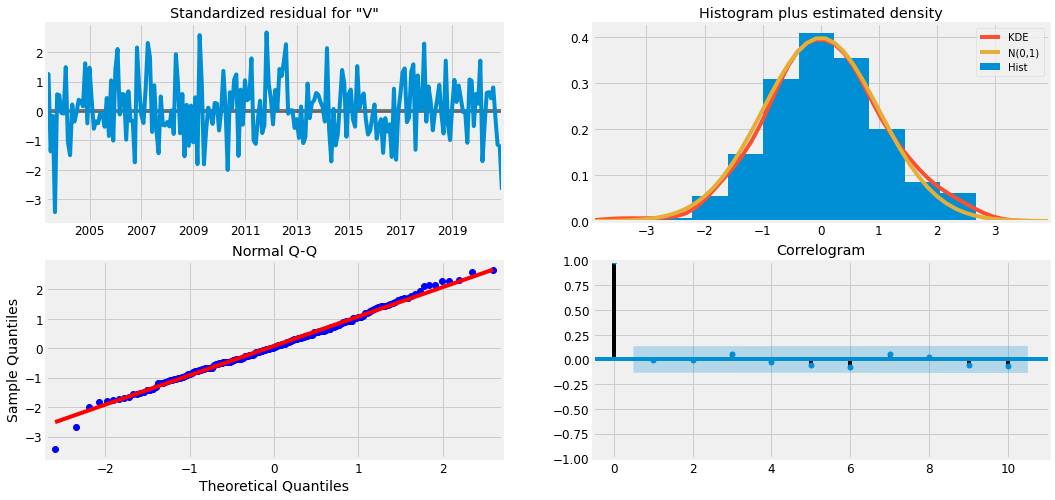

In [30]:
results.plot_diagnostics(figsize=(16, 8))

plt.show()

### The residual errors seem to followe normal distribution centered at 0 

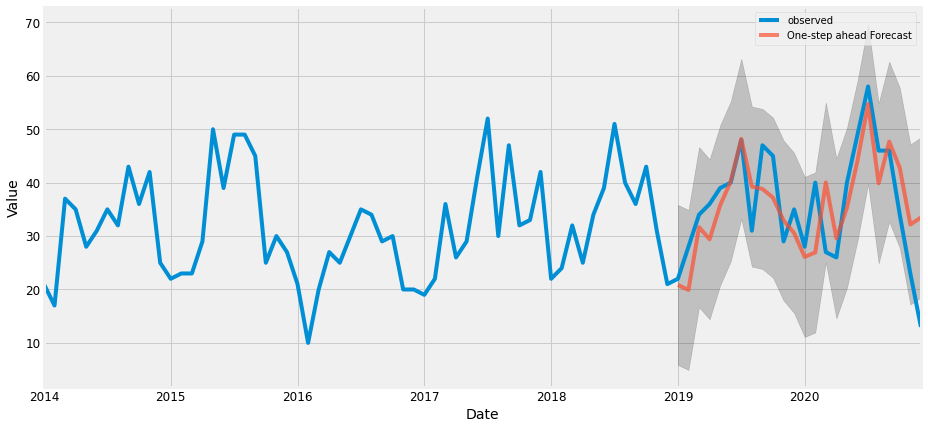

In [31]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)

pred_ci = pred.conf_int()

ax = data['2014':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')

ax.set_ylabel('Value')

plt.legend()

plt.show()

In [32]:
data_forecasted = pred.predicted_mean
data_truth = data['2019-01-01':]
mse = ((data_forecasted - data_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 57.99
The Root Mean Squared Error of our forecasts is 7.62


# Saving the model

In [33]:
outfile=open("models/ARIMA.sav","wb")
pickle.dump(results,outfile)
outfile.close()

# Trying out Holt-Winters-Exponential-Smoothning model

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Value   No. Observations:                  228
Model:             ExponentialSmoothing   SSE                          14382.213
Optimized:                         True   AIC                            976.924
Trend:                         Additive   BIC                           1031.793
Seasonal:                Multiplicative   AICC                           980.196
Seasonal Periods:                    12   Date:                 Sat, 17 Jul 2021
Box-Cox:                          False   Time:                         12:22:52
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0818669                alpha                 True
smoothing_trend          

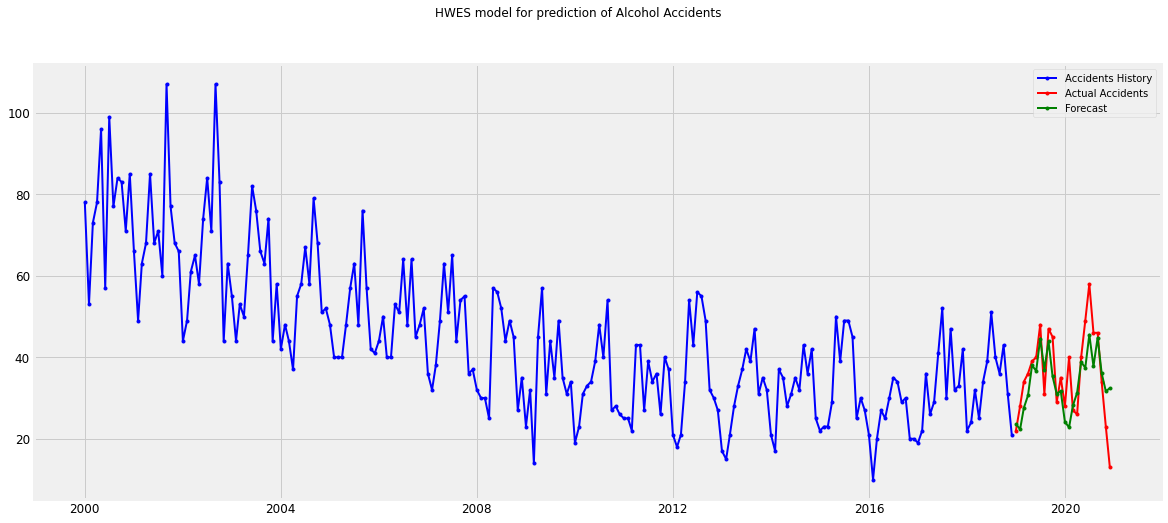

In [34]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

df_train = data.iloc[:-24]
df_test = data.iloc[-24:] # Taking last two years for testing

model = HWES(df_train, seasonal_periods=12,trend='add',seasonal='multiplicative')
fitted = model.fit(optimized=True, use_brute=True)

#printing the training summary
print(fitted.summary())

#creating an out of sample forcast for the next 24 steps beyond the final data point in the training data set
forecast = fitted.forecast(steps=24)

#plotting the training data, the test data and the forecast on the same plot
fig = plt.figure()
fig.suptitle('HWES model for prediction of Alcohol Accidents')
past, = plt.plot(df_train.index, df_train, 'b.-', label='Accidents History',linewidth=2)
future, = plt.plot(df_test.index, df_test, 'r.-', label='Actual Accidents',linewidth=2)
predicted_future, = plt.plot(df_test.index, forecast, 'g.-', label='Forecast',linewidth=2)
plt.legend(handles=[past, future, predicted_future])
plt.show()

In [35]:
data_forecasted = forecast
data_truth = data['2019-01-01':]
mse = ((data_forecasted - data_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 59.9
The Root Mean Squared Error of our forecasts is 7.74


# Saving the model

In [36]:
pickle.dump(fitted,open("models/HWES.sav","wb"))

# Deep-Learning : Nbeats model

In [37]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)


# simple batcher.
def data_generator(x, y, size):
    assert len(x) == len(y)
    batches = []
    for ii in range(0, len(x), size):
        batches.append((x[ii:ii + size], y[ii:ii + size]))
    for batch in batches:
        yield batch

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=256, thetas_dim=4, backcast_length=12, forecast_length=6, share_thetas=False) at @1447415147200
     | -- GenericBlock(units=256, thetas_dim=4, backcast_length=12, forecast_length=6, share_thetas=False) at @1447415147968
     | -- GenericBlock(units=256, thetas_dim=4, backcast_length=12, forecast_length=6, share_thetas=False) at @1447415146000
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=256, thetas_dim=8, backcast_length=12, forecast_length=6, share_thetas=False) at @1447415147104
     | -- GenericBlock(units=256, thetas_dim=8, backcast_length=12, forecast_length=6, share_thetas=False) at @1447415144944
     | -- GenericBlock(units=256, thetas_dim=8, backcast_length=12, forecast_length=6, share_thetas=False) at @1447415449200


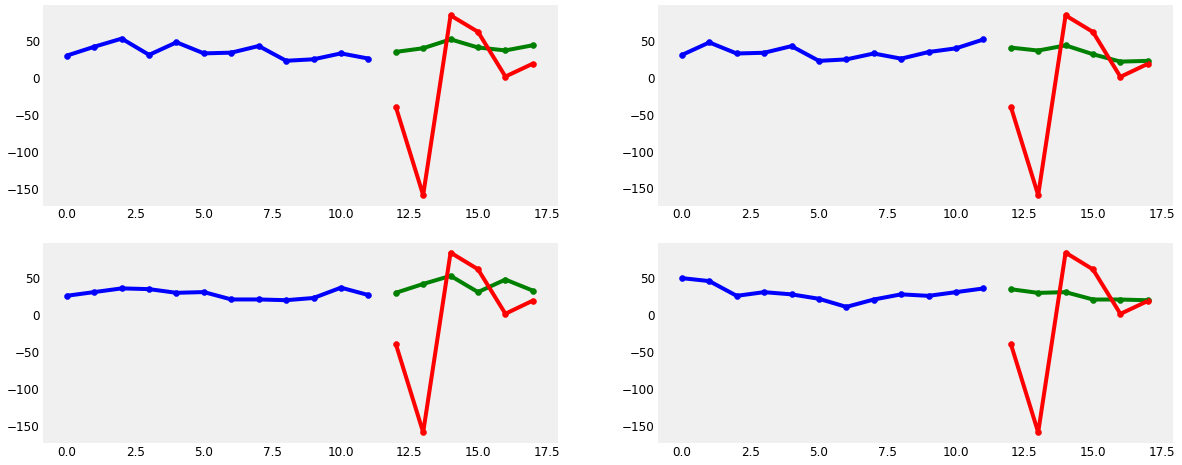

epoch = 0000, grad_step = 000019, tr_loss (epoch) = 567.176, te_loss (epoch) = 492.418


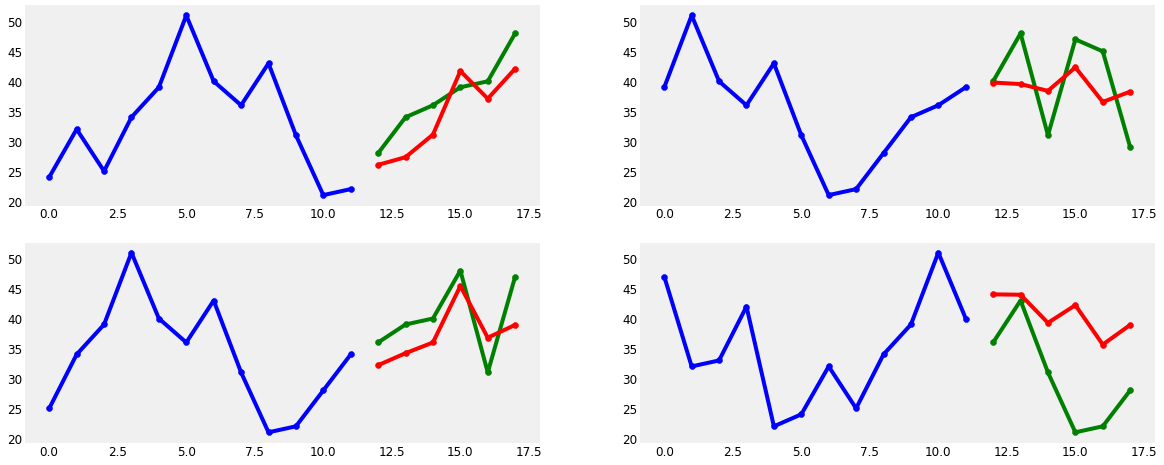

epoch = 0100, grad_step = 001919, tr_loss (epoch) = 8.706, te_loss (epoch) = 5.175


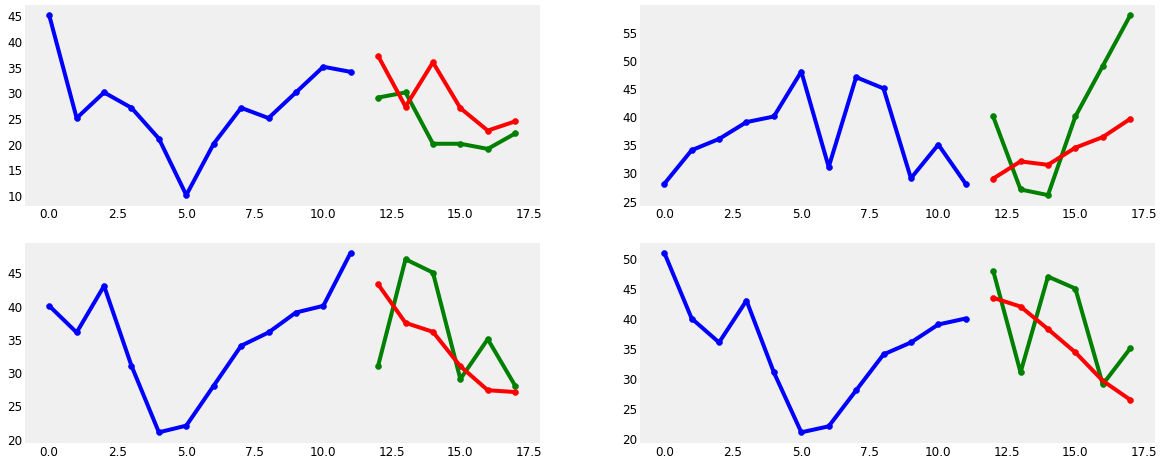

epoch = 0200, grad_step = 003819, tr_loss (epoch) = 4.945, te_loss (epoch) = 4.347


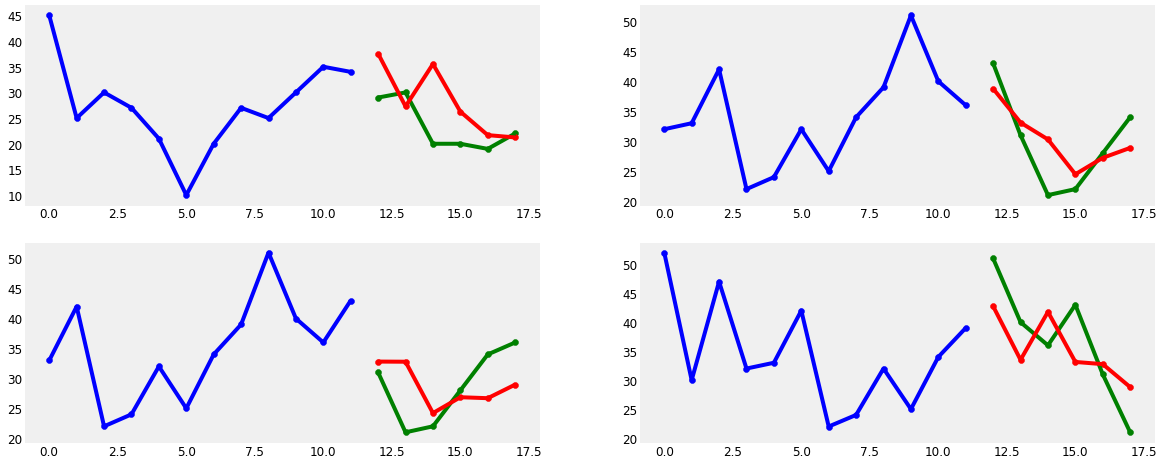

epoch = 0300, grad_step = 005719, tr_loss (epoch) = 4.422, te_loss (epoch) = 4.290


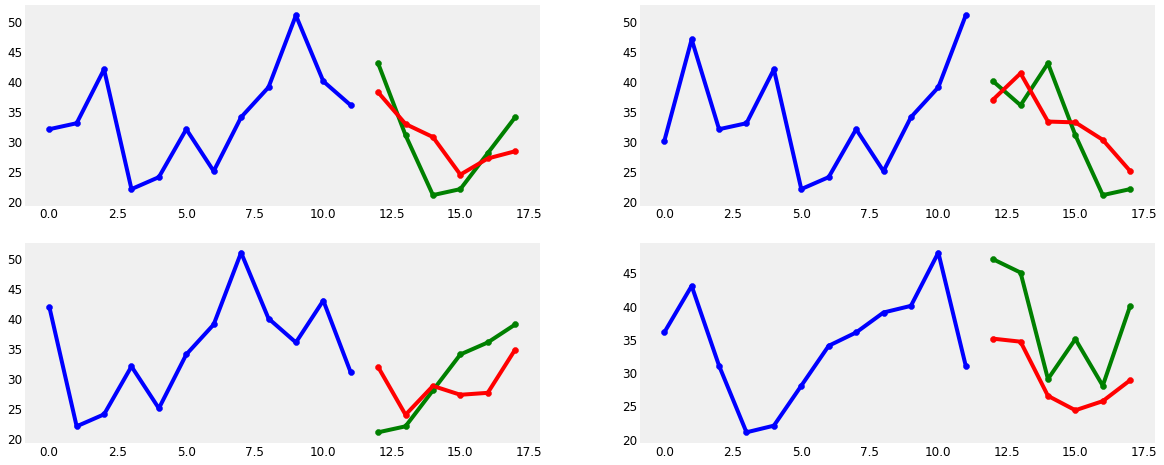

epoch = 0400, grad_step = 007619, tr_loss (epoch) = 4.138, te_loss (epoch) = 4.252


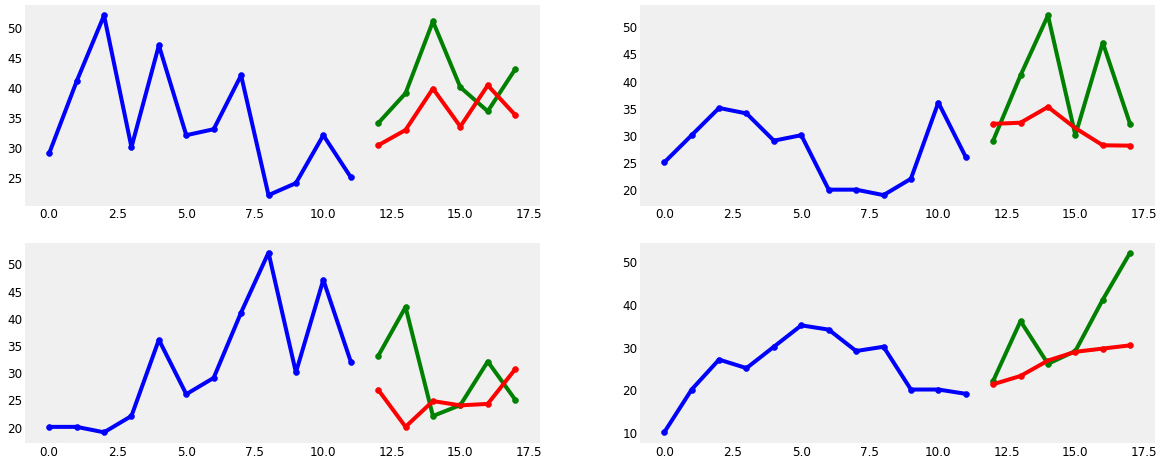

epoch = 0500, grad_step = 009519, tr_loss (epoch) = 3.899, te_loss (epoch) = 4.247


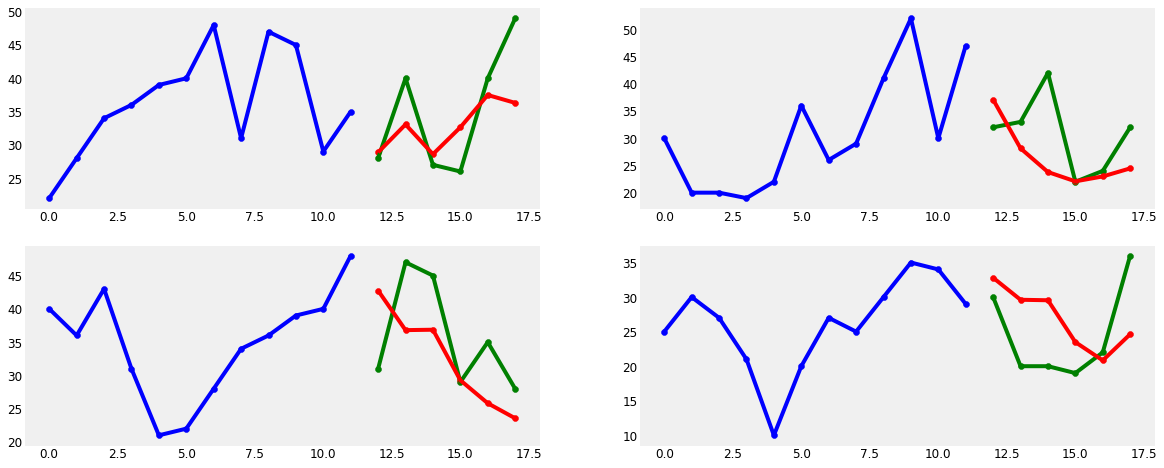

epoch = 0600, grad_step = 011419, tr_loss (epoch) = 3.673, te_loss (epoch) = 4.252


In [45]:
forecast_length = 6 # forecast time period
backcast_length = 12 # observed time period
batch_size = 10  # greater than 4 for viz

# data backcast/forecast generation.
data_input = data
data_input = data_input.values.flatten()
x, y = [], []
for epoch in range(backcast_length, len(data_input) - forecast_length):
    x.append(data_input[epoch - backcast_length:epoch])
    y.append(data_input[epoch:epoch + forecast_length])
x = np.array(x)
y = np.array(y)

# split train/test.
c = int(len(x) * 0.8)
x_train, y_train = x[:c], y[:c]
x_test, y_test = x[c:], y[c:]

# normalization.
norm_constant = np.max(x_train)
x_train, y_train = x_train / norm_constant, y_train / norm_constant
x_test, y_test = x_test / norm_constant, y_test / norm_constant

# model
net = NBeatsNet(
    stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
    forecast_length=forecast_length,
    backcast_length=backcast_length,
    hidden_layer_units=256,
)
optimiser = optim.Adam(lr=1e-5, params=net.parameters())

grad_step = 0
for epoch in range(700):
    # train.
    net.train()
    train_loss = []
    for x_train_batch, y_train_batch in data_generator(x_train, y_train, batch_size):
        grad_step += 1
        optimiser.zero_grad()
        _, forecast = net(torch.tensor(x_train_batch, dtype=torch.float).to(net.device))
        loss = F.mse_loss(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device))
        train_loss.append(loss.item())
        loss.backward()
        optimiser.step()
    train_loss = np.mean(train_loss)

    # test.
    net.eval()
    _, forecast = net(torch.tensor(x_test, dtype=torch.float))
    test_loss = F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item()
    p = forecast.detach().numpy()
    if epoch % 100 == 0:
        subplots = [221, 222, 223, 224]
        plt.figure(1)
        for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
            ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
            plt.subplot(subplots[plot_id])
            plt.grid()
            plot_scatter(range(0, backcast_length), xx, color='b')
            plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
            plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
        plt.show()
        with torch.no_grad():
            save(net, optimiser, grad_step)
        print(f'epoch = {str(epoch).zfill(4)}, '
              f'grad_step = {str(grad_step).zfill(6)}, '
              f'tr_loss (epoch) = {700 * train_loss:.3f}, '
              f'te_loss (epoch) = {700 * test_loss:.3f}')

# Saving the model

In [39]:
pickle.dump(net,open("models/Nbeats.sav","wb"))

In [46]:
model=pickle.load(open("models/Nbeats.sav","rb"))

In [47]:
def add_months(sourcedate, months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    return datetime(year, month, day)

In [51]:
pred_date="2025-05-01"
dic={}
initial=datetime.strptime("2021-01-01", '%Y-%m-%d')
inp=data[-12:].values.flatten()
while pred_date not in dic:
    _, forecast = model(torch.tensor(inp, dtype=torch.float))
    p = forecast.detach().numpy()
    predicted=p[0].tolist()
    for i in range(6):
        dic[str(add_months(initial,i).strftime('%Y-%m-%d'))]=predicted[i]
    initial=datetime.strptime(add_months(initial,6).strftime('%Y-%m-%d'),"%Y-%m-%d")
    inp=np.concatenate([inp[6:],predicted])
print(dic[pred_date])

11.564531326293945


In [56]:
fin=(pred.predicted_mean.values.flatten()+data_forecasted.values.flatten())//2

# Prophet by facebook

In [58]:
pro=pd.DataFrame()
pro['ds']=data.index # datetime column
pro['y']=data.values # values

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds       yhat  yhat_lower  yhat_upper
0 2019-01-01  22.013424   12.263715   32.309529
1 2019-02-01  20.336517   10.379981   29.954103
2 2019-03-01  24.934287   16.461094   35.007701
3 2019-04-01  29.989948   20.033762   39.796327
4 2019-05-01  37.865612   28.324103   47.863224


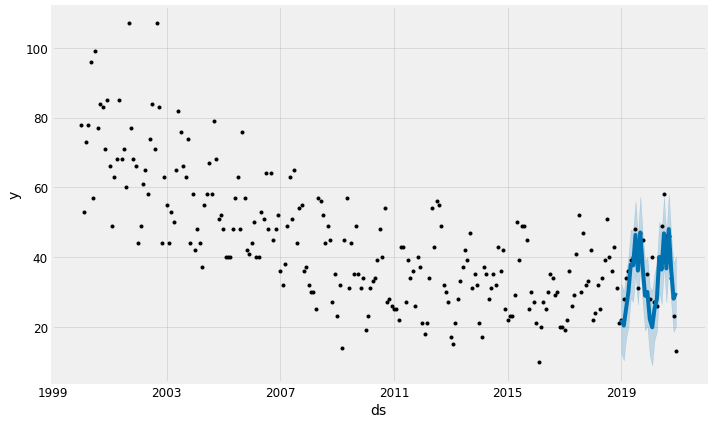

In [59]:
# load data
df_pro = pro
# prepare expected column names
df_pro.columns = ['ds', 'y']
df_pro['ds']= pd.to_datetime(df_pro['ds'])
# define the model
model = Prophet()
# fit the model
model.fit(df_pro)
# define the period for which we want a prediction
future = list()
for i in range(1, 13):
    date = '2019-%02d' % i
    future.append([date])
for i in range(1, 13):
    date = '2020-%02d' % i
    future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.show()

In [60]:
data_forecasted = np.array(forecast['yhat'])
data_truth = data['2019-01-01':]
mse = ((data_forecasted - data_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 59.71
The Root Mean Squared Error of our forecasts is 7.73


# Saving the model

In [61]:
pickle.dump(model,open("models/Prophet.sav","wb"))

# Final Conclusion

* Even though deep learning time series forecasting is the state of the art, but it falls short to analyze sudden and abrupt changes due to external factors. Also, we see that prediction far in the future have very high errors. Even though the models can predict the recent future quite accurately, it fails to do so in the long run.

* Hence we choose to use the predictions of the Sarimax model as it is a statistical model and captures any seasonality or trend present in the time series accurately and even though it might not capture sudden deviations, but it predictions have less error relative to deep learning model.